In [1]:
library(tidyverse)
library(stringr)
library(ggplot2)
library(scales)
library(kimisc)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(hrbrthemes)
library(extrafont)

extrafont::loadfonts()
convertTestName <- function(t) {
    parts <- str_match(t, "(.+)#(.+)")
    paste(parts[, 2], parts[, 3], sep = ".")
}

matched_failures <- read_csv("matched-failures.csv") %>%
    mutate(testName = convertTestName(test))

failureIDsThatAllThreeMatch <- matched_failures %>%
    filter(rerun > 0 & flakerake > 0 & flakeFlaggerRepl > 0 & isolatedRerun > 0) %>%
    select(failureID)

testsByProject <- matched_failures %>%
    group_by(slug, testName) %>%
    summarise(blah = n()) %>%
    select(-blah)
ff <- read_csv("rq3-timing-analysis/failingIndicies.flakeflagger.csv")
iso <- read_csv("rq3-timing-analysis/failingIndicies.isolated.csv")
repl <- read_csv("rq3-timing-analysis/failingIndicies.ffrepl.csv")

isot <- read_csv("rq3-timing-analysis/timing.isolated.csv")

# For flake flagger and flakeFlagger repl, we need to take the sum total of the time to run all of the tests, then call that the time to run each test
# so that we account for running the entire suite
fftRaw <- read_csv("rq3-timing-analysis/timing.flakeflagger.csv")
repltRaw <- read_csv("rq3-timing-analysis/timing.ffrepl.csv")

fft <- fftRaw %>%
    inner_join(testsByProject, by = "testName") %>%
    group_by(slug, technique) %>%
    summarise(sec.avg = sum(sec.avg)) %>%
    ungroup() %>%
    inner_join(testsByProject, by = "slug")

replt <- repltRaw %>%
    inner_join(testsByProject, by = "testName") %>%
    group_by(slug, technique) %>%
    summarise(sec.avg = sum(sec.avg)) %>%
    ungroup() %>%
    inner_join(testsByProject, by = "slug")

flakeRakeT <- read_csv("rq3-timing-analysis/flakerake5-timeToFails-through-100.csv")
flakeRakeOfflineT <- read_csv("rq3-timing-analysis/flakerake5-offline-timeToFails-through-100.csv")

failure_data_raw <- bind_rows(ff, iso, repl) %>%
    mutate(nFailures = str_count(failingRunIndices, fixed("|"))) %>%
    mutate(nFailures = ifelse(nFailures > 0, nFailures + 1, nFailures))

timing_data <- bind_rows(fft, isot, replt)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Registering fonts with R

Adobe Caslon Pro Bold already registered with pdfFonts().

Adobe Caslon Pro already registered with pdfFonts().

DejaVu Sans already registered with pdfFonts().

DejaVu Sans Mono already registered with pdfFonts().

DejaVu Serif already registered with pdfFonts().

Droid Sans Fallback already registered with pd

In [2]:
# Calculate time-to-failure for baselines
failTimes <- array(1:100, dim = c(1))
for (j in 1:100) {
    failTimes[j] <- j
}
failTimes <- data.frame(failTimes)
failure_data <- failure_data_raw %>%
    inner_join(timing_data, by = c("technique", "testName")) %>%
    select(-starts_with("timeToFails")) %>%
    full_join(failTimes, by = character()) %>%
    mutate(timeToFails = ifelse(
        nFailures > 0, (1 + sec.avg) * failTimes / (nFailures / 10000), NA)) # Raw data is just time to run the test, not time to start maven or the test runner, add 1 second as a very conservative under-estimate for how long that takes

In [3]:
# Load in pre-computed flakerake failure info
flakeRake_failures <- flakeRakeT %>%
    mutate(technique='FlakeRake', testName=convertTestName((test))) %>%
    pivot_longer(cols=starts_with('timeToFails'),names_prefix='timeToFails.',values_to='timeToFails', names_to='failTimes') %>%
    mutate(failTimes=as.integer(failTimes), timeToFails=timeToFails)%>%
    select(technique, testName, failureID, failTimes, timeToFails)

flakeRake_failuresOffline <- flakeRakeOfflineT %>%
    mutate(technique='FlakeRake (Offline)', testName=convertTestName((test))) %>%
    pivot_longer(cols=starts_with('timeToFails'),names_prefix='timeToFails.',values_to='timeToFails', names_to='failTimes') %>%
    mutate(failTimes=as.integer(failTimes), timeToFails=timeToFails)%>%
    select(technique, testName, failureID, failTimes, timeToFails)

In [4]:
# Join all of the failure info together
all_failures_by_times <- bind_rows(flakeRake_failures, failure_data, flakeRake_failuresOffline ) %>% 
    inner_join(isot, by='testName', suffix=c('','.isot')) %>% # adds a column ms.avg which was the average time to run that test in isolation
    mutate(timeToFailsRelativeOneIsolatedTestRun = timeToFails/(sec.avg.isot)) %>% mutate(task=paste(technique,failTimes))

# Create a simple table to check the results
all_failures_by_times %>%
  inner_join(failureIDsThatAllThreeMatch, by = "failureID") %>%
  group_by(technique, failTimes) %>%
  summarise(timeToFailsRelativeOneIsolatedTestRun = mean(timeToFailsRelativeOneIsolatedTestRun, na.rm = TRUE)) %>%
  filter(failTimes == 1 | failTimes == 3 | failTimes == 4 | failTimes == 5 | failTimes == 6 |
    failTimes == 7 | failTimes == 8 | failTimes == 9 | failTimes == 10 | failTimes == 25 | failTimes == 50 | failTimes == 100) %>%
  pivot_wider(names_from = "failTimes", values_from = timeToFailsRelativeOneIsolatedTestRun) %>%
  kable("html", booktabs = TRUE, linesep = "", digits = 0, escape = FALSE, format.args = list(
    big.mark = ",",
    scientific = FALSE
  )) %>%
  kable_styling(latex_options = "striped") %>%
  as.character() %>%
  display_html()

`summarise()` has grouped output by 'technique'. You can override using the `.groups` argument.



technique,1,3,4,5,6,7,8,9,10,25,50,100
ffrepl,"42,223","126,669","168,892","211,115","253,339","295,562","337,785","380,008","422,231","1,055,577","2,111,154","4,222,309"
flakeflagger,"18,919","56,757","75,676","94,596","113,515","132,434","151,353","170,272","189,191","472,978","945,955","1,891,910"
FlakeRake,"16,194","16,194","16,516","16,611","16,706","16,887","16,984","17,081","17,589","22,831","31,805","49,464"
FlakeRake (Offline),359,"1,077","1,436","1,796","2,155","2,514","2,873","3,232","3,591","8,978","17,955","35,910"
isolated,"2,866","8,599","11,465","14,331","17,198","20,064","22,930","25,797","28,663","71,657","143,314","286,628"


`summarise()` has grouped output by 'technique'. You can override using the `.groups` argument.

Saving 6.67 x 6.67 in image



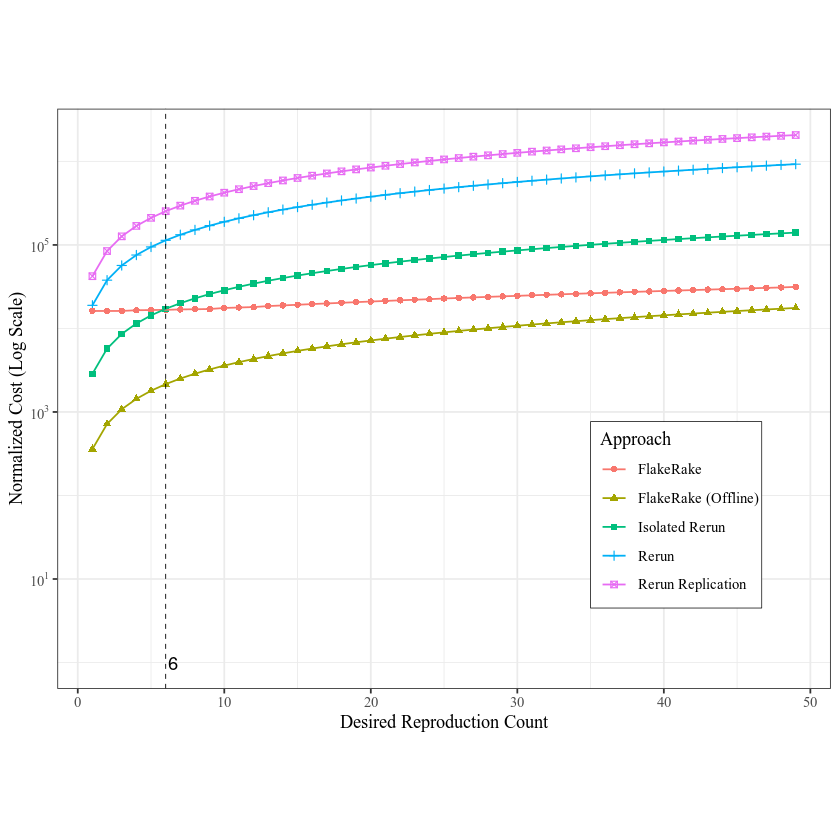

In [5]:
# Turn the above table into a line plot
failuresFoundByAll <- all_failures_by_times %>%
  inner_join(failureIDsThatAllThreeMatch, by = "failureID") %>%
  group_by(technique, failTimes) %>%
  summarise(timeToFailsRelativeOneIsolatedTestRun = mean(timeToFailsRelativeOneIsolatedTestRun, na.rm = TRUE))

ggplot(
  failuresFoundByAll %>% filter(failTimes < 50) %>% mutate(
    technique =
      ifelse(technique == "ffrepl", "Rerun Replication",
        ifelse(technique == "flakeflagger", "Rerun",
          ifelse(technique == "isolated", "Isolated Rerun", technique)
        )
      )
  ),
  aes(y = timeToFailsRelativeOneIsolatedTestRun, x = failTimes, color = technique, shape = technique)
) +
  geom_point() +
  geom_line() +
  scale_y_continuous(trans = "log10", labels = trans_format("log10", math_format(10^.x))) +
  xlab("Desired Reproduction Count") +
  theme_bw() +
  geom_vline(xintercept = 6, linetype = 2, size = 0.25) +
  annotate(
    geom = "text", x = 6.5, y = 1, label = "6",
    color = "black"
  ) +
  ylab("Normalized Cost (Log Scale)") +
  theme(legend.position = "bottom") +
  theme(
    plot.title = element_text(family = "Times New Roman"),
    plot.subtitle = element_text(family = "Times New Roman"),
    axis.title.x = element_text(family = "Times New Roman"),
    axis.title.y = element_text(family = "Times New Roman"),
    axis.text.x = element_text(family = "Times New Roman"),
    legend.text = element_text(family = "Times New Roman"),
    legend.title = element_text(family = "Times New Roman"),
    axis.text.y = element_text(family = "Times New Roman")
  ) +
  guides(color = guide_legend(title = "Approach"), shape = guide_legend(title = "Approach")) +
  theme(
    aspect.ratio = 0.75,
                legend.position=c(0.8,0.3),
    legend.background = element_rect(size = 0.2, linetype = "solid", color = "black"),
    #             legend.box="horizontal",
    # legend.key.size=unit(0.1,"cm")
  )

ggsave("reproduction-timing.pdf")